In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn 
import math
import time
import random
np.random.seed(20)
import mpl_toolkits.axisartist as axisartist

#plotting setting
size=10;f=10
figsize=(8,6)

import sys
sys.path.append("..")

from ML_estimator import *
from Evaluation import *
from Basic import *


In [18]:
filepath='C:/tests/Setup/'

# Linear array Setup

In [19]:
#Linear array
N=10 # number of elements
lmb=2e-3 # wavelength of the signal
d=0.25*lmb # distance between 2 adjacent elements


arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location
R_near=near_field_Boundary(lmb,arr_dim)
arr_center=0.5*arr_dim

#target
targets = sample_in_half_circle(R_near,1)+np.array([arr_center,0])
target = targets[0]

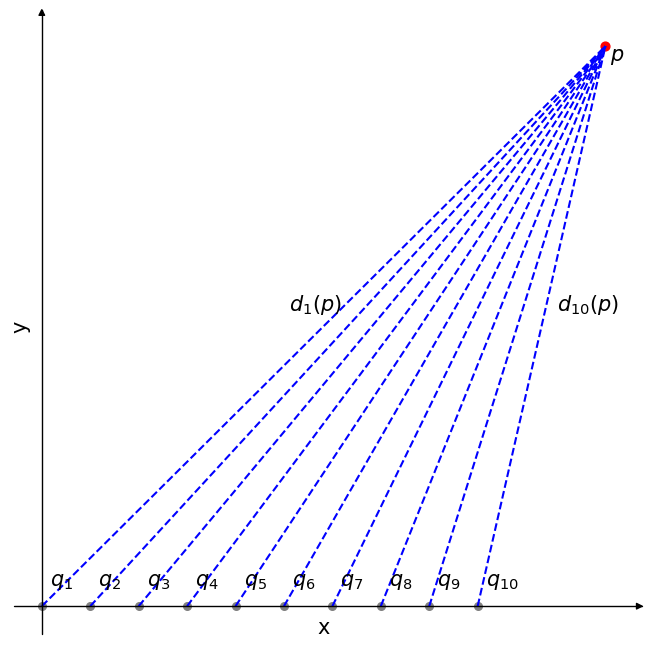

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = axisartist.Subplot(fig, 111)  
fig.add_axes(ax)

ax.axis[:].set_visible(False)

#Set new axis style
ax.axis["x"] = ax.new_floating_axis(0,0)
ax.axis["x"].set_axisline_style("-|>", size = 1.0)

ax.axis["y"] = ax.new_floating_axis(1,0)
ax.axis["y"].set_axisline_style("-|>", size = 1.0)

ax.axis["x"].set_axis_direction("bottom")
ax.axis["y"].set_axis_direction("left")



#Set the label
ax.axis['x'].label.set_text('x')
ax.axis['x'].label.set_fontsize(15)

ax.axis['y'].label.set_text('y')
ax.axis['y'].label.set_fontsize(15)

#Set the axis ticks invisible
plt.xticks([])
plt.yticks([])

# plt.xlim(-0.02,0.02)
# plt.ylim(-0.02, 0.02)



#plot the data
plt.scatter(arr[:,0],arr[:,1], c='grey',s=30)
plt.scatter(target[0],target[1],color='r',s=40)

#distance 
for i in range(arr.shape[0]):
    plt.plot([arr[i,0],target[0]],[arr[i,1],target[1]],color='b',linewidth=1.5,linestyle='--')

#annotation

for i,xy in enumerate(zip(arr[:,0], arr[:,1])):
    plt.annotate(r"$q_{%r}$" %(i+1), xy=xy, xytext=(8,20), textcoords='offset pixels',fontsize=15)

plt.annotate(r"$p$", xy=(target[0],target[1]), xytext=(5,-15), textcoords='offset pixels',fontsize=15)

plt.annotate(r"$d_1(p)$", xy=(0.5*(arr[0,0]+target[0]),0.5*(arr[0,1]+target[1])), xytext=(-35,15), textcoords='offset pixels',fontsize=15)
plt.annotate(r"$d_{10}(p)$", xy=(0.5*(arr[-1,0]+target[0]),0.5*(arr[-1,1]+target[1])), xytext=(15,15), textcoords='offset pixels',fontsize=15)

plt.savefig(filepath+'Set_up_1.png')
plt.savefig(filepath+'Set_up_1.eps')

In [21]:
def position_noise_to_phase_generate(N,lmb,d,targets,position_noise_std,phi_0): #adding noise to posititon, then generate a noise-free phase
    # noise std is position noise
    # Array
    arr_dim=d*(N-1) # dimension of the array
    arr=array(N,arr_dim,0) # array elements location

    #Prepare arrays for results
    num_sam=1
    true_targets=np.empty([len(targets),num_sam,2])
    noisy_targets=np.empty([len(targets),num_sam,2])
    phase_measurements=np.empty([len(targets),num_sam,N])
    for i in range (len(targets)):
        for j in range(num_sam):
            true_targets[i,j]=targets[i]
            noisy_targets[i,j]=true_targets[i,j]+lmb*randn(2)*position_noise_std
            dist=np.array([np.linalg.norm(arr[n]-noisy_targets[i,j]) for n in range(N)])#distance between the elements and target
            phase_measurements[i,j]=(4*np.pi/lmb*dist+phi_0)%(2*np.pi)
    return true_targets,phase_measurements

In [22]:
def noise_free_phase_generate(N,lmb,d,targets,phi_0):
    # noise std is position noise
    # Array
    arr_dim=d*(N-1) # dimension of the array
    arr=array(N,arr_dim,0) # array elements location

    #Prepare arrays for results
    num_sam=1
    true_targets=np.empty([len(targets),num_sam,2])
    noise_free_phase_measurements=np.empty([len(targets),num_sam,N])
    for i in range (len(targets)):
        for j in range(num_sam):
            true_targets[i,j]=targets[i]
            dist=np.array([np.linalg.norm(arr[n]-true_targets[i,j]) for n in range(N)])#distance between the elements and target
            noise_free_phase_measurements[i,j]=(4*np.pi/lmb*dist+phi_0)%(2*np.pi)
    return true_targets,noise_free_phase_measurements

In [23]:
noise_dB = 10
position_noise_std=Single_Noise_dB_to_std(noise_dB)

_,one_noisy_phase_observation=position_noise_to_phase_generate(N,lmb,d,targets,position_noise_std,phi_0=1) 
_,one_noise_free_phase_observation=noise_free_phase_generate(N,lmb,d,targets,phi_0=1)
one_noisy_phase_observation = one_noisy_phase_observation[0,0]
one_noise_free_phase_observation = one_noise_free_phase_observation[0,0]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


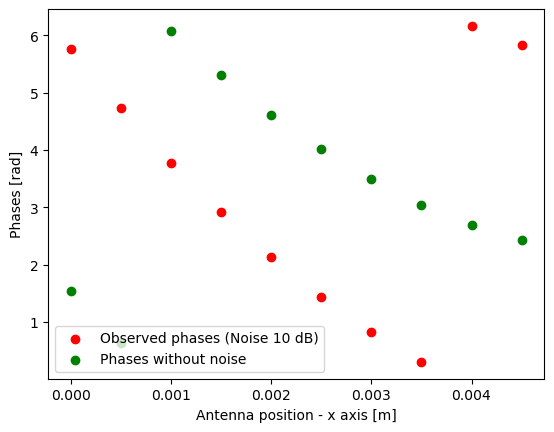

In [24]:
plt.figure()
plt.scatter(arr[:,0],one_noisy_phase_observation,color='red')
plt.scatter(arr[:,0],one_noise_free_phase_observation,color='green')
plt.xlabel('Antenna position - x axis [m]')
plt.ylabel('Phases [rad]')
plt.legend([f'Observed phases (Noise {noise_dB} dB)','Phases without noise'])
plt.savefig(filepath+'Set_up_noise.png')
plt.savefig(filepath+'Set_up_noise.eps')

# Basic localization techniques

## Trilateration

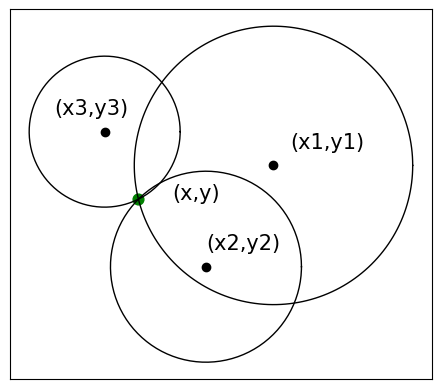

In [25]:
fig, ax = plt.subplots()
theta = np.linspace(0, 2 * np.pi, 200)

# three circles
center1=[4,1]
center2=[2,-2]
center3=[-1,2]
R1=np.sqrt(17)
R2=np.sqrt(8)
R3=np.sqrt(5)

x = center1[0]+R1*np.cos(theta)
y = center1[1]+R1*np.sin(theta)
ax.plot(x, y, color="black", linewidth=1)

x = center2[0]+R2*np.cos(theta)
y = center2[1]+R2*np.sin(theta)
ax.plot(x, y, color="black", linewidth=1)

x = center3[0]+R3*np.cos(theta)
y = center3[1]+R3*np.sin(theta)
ax.plot(x, y, color="black", linewidth=1)

# the target and antennas
ax.scatter(0,0,60,c='green')
ax.scatter(center1[0],center1[1],c='black')
ax.scatter(center2[0],center2[1],c='black')
ax.scatter(center3[0],center3[1],c='black')

ax.annotate('(x,y)',(0,0),xytext=(1,0),fontsize=15)
ax.annotate('(x1,y1)',center1,xytext=(4.5,1.5),fontsize=15)
ax.annotate('(x2,y2)',center2,xytext=(2,-1.5),fontsize=15)
ax.annotate('(x3,y3)',center3,xytext=(-2.5,2.5),fontsize=15)

# plotting in a square 
ax.set_aspect(1)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator()) 

fig.savefig(filepath+"trilateration.png")
fig.savefig(filepath+"trilateration.eps")

## Multilateration based on range differences

In [26]:
def drawhyperbola(a,b,F1,color):
    x1=np.arange(-a,-20*a,-1e-6)
    x2=np.arange(a,20*a,1e-6)
    y1=(b/a)*np.sqrt(x1*x1-a**2)
    y2=-(b/a)*np.sqrt(x2*x2-a**2)
    plt.plot(F1+a+x1,y1,c=color)
    plt.plot(F1+a+x1,y2,c=color)
    plt.plot(F1+a+x2,y1,c=color)
    plt.plot(F1+a+x2,y2,c=color)

R near-field is:0.00225[m]


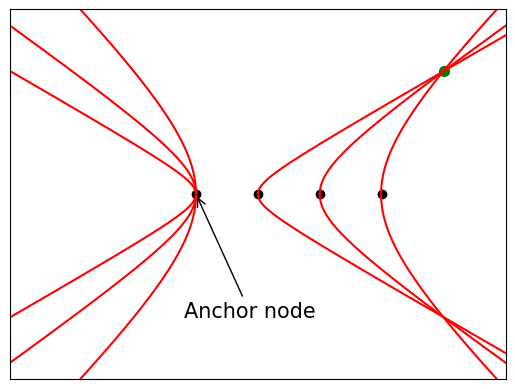

In [27]:
#linear array with 4 elements
N=4 # number of elements
lmb=2e-3 # wavelength of the signal
d=0.25*lmb # distance between 2 adjacent elements


arr_dim=d*(N-1) # dimension of the array
arr_multilateration=array(N,arr_dim,0) # array elements location
R_near=near_field_Boundary(lmb,arr_dim)
arr_center=0.5*arr_dim
print(f'R near-field is:{R_near}[m]')

# target
target = [0.002,0.0001]
# dist = target-np.array([arr_center,0])
# print(np.linalg.norm(dist))

# range(distance) difference
d_n=np.linalg.norm(target-arr_multilateration,axis=1)
delta_d=np.abs(d_n[1:]-d_n[0])
# print(delta_d)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(arr_multilateration[:,0],arr_multilateration[:,1],c='black')
plt.scatter(target[0],target[1],c='green',s=50)


for i in range(len(delta_d)):
    a=0.5*abs(delta_d[i])
    c=0.5*(i+1)*d
    b=np.sqrt(c**2-a**2)
    drawhyperbola(a,b,arr_multilateration[0,0],'red')
    
    
# annotation
x0=arr_multilateration[0,0]
y0=arr_multilateration[0,1]
plt.annotate('Anchor node', fontsize=15,xy=(x0, y0), xytext=(x0-0.2*d, y0 -0.2*d), arrowprops=dict(arrowstyle='->'))



plt.xlim([-3*d,5*d])
plt.ylim([-1.5*target[1],1.5*target[1]])
# plt.axis('off')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



plt.savefig(filepath+"multilateration.png")
plt.savefig(filepath+"multilateration.eps")